## U shape PHP dynamics with multiple liquid slugs - (no heat transfer currently)

In [1]:
using Plots
pyplot()

Plots.PyPlotBackend()

In [2]:
using DifferentialEquations

In [3]:
using DelimitedFiles

In [4]:
cd(dirname(pwd()))
cd("src")

include("Systems.jl")
include("Tools.jl")

using ..Systems
using ..Tools

## Parameters of the PHP

In [20]:
    ω0 = [sqrt(1.2e004), sqrt(1.2e004)];
    ℘ = [1.2e005, 1.2e005];


    Θ = 0.15;
    θe = 1 + Θ;
    θc = 1 - Θ;
    
    He = 3000.0;
    Hc = 3000.0;
    
    X0 = 0.5;

    γ = 1.4;

In [21]:
    L = 8.0  # total length of the pipe when streched to a 1D pipe
    L2D = 2.0 # the actual length of the bended pipe in the real world
    alpha = pi/2 # inclination angle 

1.5707963267948966

## Pipe definition

In [22]:
tube = Tube(L,L2D,alpha)

Tube(8.0, 2.0, 1.5707963267948966)

## Evaporator and condenser definition

In [23]:
Xe = map(tuple, [0.0; 3.0; 7.0], [1.0; 5.0; 8.0])
evap = Evaporator(He,θe,Xe)

Evaporator(3000.0, 1.15, Tuple{Float64,Float64}[(0.0, 1.0), (3.0, 5.0), (7.0, 8.0)])

In [24]:
Xc = map(tuple, [1.0; 5.0], [3.0; 7.0])
cond = Condenser(Hc,θc,Xc)

Condenser(3000.0, 0.85, Tuple{Float64,Float64}[(1.0, 3.0), (5.0, 7.0)])

## Vapor plug and liquid slug initialization

In [25]:
X0 = [(1.0,3.0),(5.5,6.0)]
dXdt0 = [(0.0,0.0),(0.0,0.0)]
liquids=LiquidSlug(γ,ω0,℘,X0,dXdt0)

LiquidSlug(1.4, [109.54451150103323, 109.54451150103323], [120000.0, 120000.0], Tuple{Float64,Float64}[(1.0, 3.0), (5.5, 6.0)], Tuple{Float64,Float64}[(0.0, 0.0), (0.0, 0.0)])

In [26]:
P = [1.0,1.0,1.0];
vapors=VaporPlug(γ,P)

VaporPlug(1.4, [1.0, 1.0, 1.0])

## Construct the system

In [27]:
sys0 = PHPSystem(tube,evap,cond,liquids,vapors)

PHPSystem(Tube(8.0, 2.0, 1.5707963267948966), Evaporator(3000.0, 1.15, Tuple{Float64,Float64}[(0.0, 1.0), (3.0, 5.0), (7.0, 8.0)]), Condenser(3000.0, 0.85, Tuple{Float64,Float64}[(1.0, 3.0), (5.0, 7.0)]), LiquidSlug(1.4, [109.54451150103323, 109.54451150103323], [120000.0, 120000.0], Tuple{Float64,Float64}[(1.0, 3.0), (5.5, 6.0)], Tuple{Float64,Float64}[(0.0, 0.0), (0.0, 0.0)]), VaporPlug(1.4, [1.0, 1.0, 1.0]))

In [28]:
typeof(sys0)

PHPSystem

## Construct the state vector U

In [29]:
Lvaporplug = XptoLvaporplug(X0,sys0.tube.L)
M = P.^(1/γ).* Lvaporplug
u=XMtovec(X0,dXdt0,M)

11-element Array{Float64,1}:
 1.0
 3.0
 5.5
 6.0
 0.0
 0.0
 0.0
 0.0
 1.0
 2.5
 2.0

 ## $\textbf{U}=\left(\begin{array}{c}  X_{p1}   \\  X_{p2} \\  X_{p3} \\  X_{p4} \\ \frac{\mathrm{d} X_{p1}}{\mathrm{d} \tau}  \\ \frac{\mathrm{d} X_{p2}}{\mathrm{d} \tau}   \\ \frac{\mathrm{d} X_{p3}}{\mathrm{d} \tau}   \\ \frac{\mathrm{d} X_{p4}}{\mathrm{d} \tau} \\ M_{1} \\ M_{2} \\ M_{3} \end{array}\right)$.

## Construct the time marching of U

In [30]:
function solve!(du,u,p,t)
    

    (Xp,dXdt0,M)=vectoXM(u)

    
    numofliquidslug = Integer( (length(u) + 1)/3/2 )
    sys0 = p
    
    γ = sys0.liquidslug.γ
    ω0 = sys0.liquidslug.ω0
    ℘ = sys0.liquidslug.℘
    Lvaporplug = XptoLvaporplug(Xp,sys0.tube.L)
#     Lliquidslug = XptoLliquidslug(Xp)
    height = getheight(Xp,L2D,alpha)

    
    
    # get P from M and γ
    P = (M./Lvaporplug).^(γ) 
    
    
    # get θ from P and γ
    θ = P.^((γ-1)/γ)

    
    for i = 1:numofliquidslug
        du[2*i-1] = u[2*numofliquidslug+2*i-1]
        du[2*i] = du[2*i-1]
        
        du[2*numofliquidslug + 2*i-1] = -32*u[2*numofliquidslug + 2*i-1] - (ω0[i]^2)*(0.5*(height[i][end]-height[i][1])) + ℘[i]*(P[i]-P[i+1])
        du[2*numofliquidslug + 2*i] = du[2*numofliquidslug + 2*i-1]
    end

    return du
    
end

solve! (generic function with 1 method)

## Solve the constructed ODE for U

In [31]:
p = sys0
tspan = (0.0, 0.1);
prob = ODEProblem(solve!, u, tspan, p)
sol = solve(prob, RK4(), adaptive=false, dt=1.0e-5);

## Convert and plot the results

In [32]:
X1hist=zeros(length(sol));
X2hist=zeros(length(sol));
X3hist=zeros(length(sol));
X4hist=zeros(length(sol));
M2hist=zeros(length(sol));
thist=zeros(length(sol));

for i = 1:length(sol)
    X1hist[i]=sol[i][1]
    X2hist[i]=sol[i][2]
    X3hist[i]=sol[i][3]
    X4hist[i]=sol[i][4]
    thist[i]=sol.t[i]
end

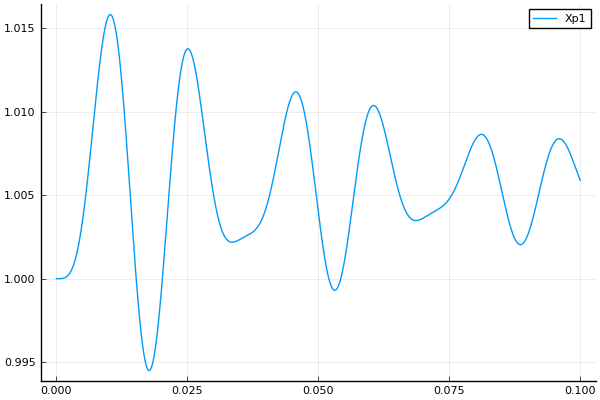

In [33]:
plot(thist,X1hist,label="Xp1")